Reference MLP paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

- The vectors will start all randomly placed in the 30dim space.
- As we train the model, it will learn the semantically similar words will get closer to each other.
- This helps us to generalize to unseen cases. If we know cat-dog are similar and likewise for (a,the) we can generalize to many unseen words.

#### Go over the neural architecture diagram
- Input: some context window of words
- The lookup table is shared for all timestamps
- Some number of hidden units (hyperparam) with tanh activation
- Softmax at the latest layer to predict the next word
- During training, maximize the probability of the next words
- Learned through backprop
- Ignore the residual connections!

In [132]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [134]:
# read all words
words = open('../hafta12/assets/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [135]:
len(words)

32033

In [136]:
special_char = '.'
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[special_char] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build the dataset
Explain what is Y and block size

In [11]:
block_size = 3 # context length

X,Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->',itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [53]:
output_dim = 2 #acceptable since we only have 27 chars in our model
vocab_size = 27
C = torch.randn((vocab_size,output_dim))


In [17]:
# How to access
C[5]

tensor([ 1.1187, -0.2084])

In [30]:
# One-hot
# remember casting to float
index = F.one_hot(torch.tensor(5),num_classes=vocab_size).float()

In [31]:
index

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
#identical 
index @ C 

tensor([ 1.1187, -0.2084])

Since it is the same thing, we will basically index and discard the one-hot approach.

In [35]:
# Pytorch indexing is highly flexible
# It can be array as well
C[torch.tensor([1,2,3,3,3])]

tensor([[ 2.9992, -1.2235],
        [ 0.4842,  0.3169],
        [ 0.7539, -1.5278],
        [ 0.7539, -1.5278],
        [ 0.7539, -1.5278]])

In [36]:
# We can even do this
C[X].shape

torch.Size([32, 3, 2])

In [37]:
X[13,2]

tensor(1)

In [38]:
C[X][13,2]

tensor([ 2.9992, -1.2235])

In [39]:
C[1]

tensor([ 2.9992, -1.2235])

In [40]:
# Embed everything simultaneously
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [41]:
# initialize the model
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [42]:
# How to concat the three inputs so we can multiply with W
# Maaaany ways to achieve this 

one way: https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat 

In [52]:
# Manual
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:],],dim=1).shape

torch.Size([32, 6])

In [53]:
# Generalized way
# Use unbind which removes a tensor dimension

https://pytorch.org/docs/stable/generated/torch.unbind.html#torch.unbind 

In [54]:
torch.unbind(torch.tensor([[1,2],[2,3]]))

(tensor([1, 2]), tensor([2, 3]))

In [56]:
torch.unbind(emb,dim=1)[0].shape

torch.Size([32, 2])

In [57]:
len(torch.unbind(emb,dim=1))

3

In [58]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [59]:
emb_ = torch.unbind(emb,dim=1)

In [60]:
len(emb_),emb_[0].shape

(3, torch.Size([32, 2]))

In [61]:
con_emb_ = torch.cat(emb_,dim=1)

In [62]:
con_emb_.shape

torch.Size([32, 6])

In [63]:
# There is actually much more efficient way of doint this
# Without swapping memories
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [64]:
a.shape

torch.Size([18])

In [65]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

Extremely efficient because the underlying storage doesn't change!! 
We are only manipulating how this sequence is interpreted so we don't make any memory operations!! see `a.storage()`.

Optional reading on this: http://blog.ezyang.com/2019/05/pytorch-internals/

In [68]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [69]:
emb.shape

torch.Size([32, 3, 2])

In [71]:
emb.view(32,6) == con_emb_

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [73]:
a = torch.arange(24)
a.view(3,4,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11],
         [12, 13],
         [14, 15]],

        [[16, 17],
         [18, 19],
         [20, 21],
         [22, 23]]])

In [74]:
a.view(6,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]])

In [75]:
# alternatively you can also use -1 for the first dim
h = emb.view(emb.shape[0],6) @ W1 +b1

In [77]:
h = torch.tanh(h)

In [78]:
h.shape

torch.Size([32, 100])

In [79]:
# reminder about broadcasting of b1
# 32, 100
# (1) 100
# to be safe you can also declare b1 as torch.randn((1,100))

In [80]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [81]:
logits = h@ W2 +b2

In [82]:
logits.shape

torch.Size([32, 27])

In [83]:
# exponentiate to get the fake counts
counts = logits.exp()

In [87]:
# another broadcasting here
prob = counts / counts.sum(1,keepdims=True)

In [89]:
prob.shape

torch.Size([32, 27])

In [92]:
#get probs for correct continuations
# how to index it
prob[torch.arange(32),Y]

tensor([4.4364e-08, 4.6486e-07, 6.0307e-09, 9.3952e-12, 4.2877e-03, 4.5098e-08,
        2.2291e-07, 2.3784e-05, 2.3665e-10, 2.0776e-06, 8.2781e-07, 4.2196e-02,
        1.8992e-05, 2.2370e-05, 1.5717e-03, 9.9949e-06, 3.0955e-07, 9.1311e-10,
        2.2856e-03, 2.0201e-05, 2.7432e-08, 5.1033e-16, 6.4684e-11, 7.3463e-09,
        1.0098e-13, 3.5404e-10, 4.9650e-08, 1.1677e-10, 1.3497e-03, 2.6709e-07,
        1.0573e-05, 6.5300e-07])

In [93]:
#MLE!! negative log likelihood
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(15.7016)

In [94]:
# -------- putting it all together ----------------
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [100]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [101]:
sum(p.nelement() for p in parameters)

3481

In [105]:
# forward pass
h = torch.tanh(C[X].view(-1,6)@ W1+b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1,keepdims=True)
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(16.8879)

further improve. Lets not reinvent the wheel. Since we are doing classification, we can use the pre-built cross_entropy from torch. 

Reference: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

In [106]:
# Get the same thing!
loss2 = F.cross_entropy(logits,Y)
loss2

tensor(16.8879)

In [107]:
# forward pass
h = torch.tanh(C[X].view(-1,6)@ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)

Why actually always use F.cross_entropy?

1. Efficiency: 

- PyTorch uses fused kernels for fast calculation
- Since the expression is pre-built, pytorch knows exactly what to do on the backward step.
- On the contrary, if we hand write the long expression, pytorch will have to make 3-4 separate backward steps.
- This is similar to the case the we built the `_backward()` operation for `tanh()` in lecture 1. In that case the backward was single operation. we did not calculate the backward for all individual steps like `2*x` or `math.exp(.)` 

2. Numerically well behaved!!


In [ ]:
# Explain 2

In [108]:
# forward pass
h = torch.tanh(C[X].view(-1,6)@ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)

In [111]:
logits = torch.tensor([-2,-3,-0,1000])
counts = logits.exp()
probs = counts/counts.sum()
probs

tensor([0., 0., 0., nan])

In [113]:
# because e^1000 is overflowing
counts

tensor([0.1353, 0.0498, 1.0000,    inf])

In [115]:
# subtract the max  trick for preventing overflow
logits = torch.tensor([-5,-3,0,1000]) - 1000
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., 1.])

In [116]:
# Continue training from here

In [117]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [118]:
sum(p.nelement() for p in parameters)

3481

In [119]:
for p in parameters:
    p.requires_grad= True

In [121]:
epoch = 100
for _ in range(epoch):
    # forward pass
    emb = C[X] # shape (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.2849053740501404


Loss is super low because we are overfitting to 32 samples!! We have 3481 params to fit 32 samples

Go over why it is not zero? Because there are some ambiguous cases such as "..." -> "e" or "o".

We could only overfit to cases where there is one single answer!!

In [124]:
logits.max(1)

torch.return_types.max(
values=tensor([ 8.6770, 13.5366, 12.1110, 12.9143, 16.6655,  8.6770, 14.2060, 13.1895,
        11.1739, 13.4428, 15.1191, 20.6045,  8.6770, 14.8853, 10.4620, 15.5376,
         8.6770, 12.6185, 14.6243, 14.3542, 13.2918, 15.6934, 13.5731, 16.5784,
        18.7177,  8.6770, 14.3525, 14.5067, 18.2000, 12.0925, 17.6595, 18.2331],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [125]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

### Let's fit the whole dataset!

In [137]:
block_size = 3 # context length

X,Y = [], []
for w in words:
    
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [138]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [141]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [142]:
for p in parameters:
    p.requires_grad= True

In [136]:
epoch = 10
for _ in range(epoch):
    # forward pass
    emb = C[X] # 
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad


16.261137008666992
14.354217529296875
13.208730697631836
12.27278995513916
11.476091384887695
10.803886413574219
10.234297752380371
9.751381874084473
9.338600158691406
8.974411010742188


#### Each pass is taking super long. Let's fix that by using mini-batch GD

In [138]:
torch.randint(0,X.shape[0],(32,))

tensor([ 16484, 106304, 205810,  72380,  25389, 216832,  46905,   2905, 142763,
        119890,  12897,  95169, 136946, 128679,  97235,  52561,  97842, 217865,
           298,  62415, 106205, 122780, 160425, 221446, 155054,  43179,  32255,
        225916, 201485,  64244, 116188, 127472])

In [139]:
ixs = torch.randint(0,X.shape[0],(32,))

In [143]:
ixs.shape

torch.Size([32])

In [145]:
mini_batch = C[X[ixs,:]]

In [146]:
mini_batch.shape

torch.Size([32, 3, 2])

In [149]:
Y[ixs].shape

torch.Size([32])

In [143]:
# Mini-batch GD
epoch = 1000
batch_size = 32
for _ in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,X.shape[0],(batch_size,))
    mini_batch = X[ixs,:]
    mini_batch_y = Y[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.0 * p.grad


17.66386604309082
16.80512046813965
14.54172420501709
16.965679168701172
14.482089042663574
13.866053581237793
15.381904602050781
14.528257369995117
16.104402542114258
15.2438383102417
15.150202751159668
14.86290168762207
16.770986557006836
15.984189987182617
17.569469451904297
17.20720100402832
17.67346954345703
17.00666046142578
18.211076736450195
16.926029205322266
15.183862686157227
15.703333854675293
16.09029769897461
15.9874267578125
14.462736129760742
17.46344566345215
16.339752197265625
15.467147827148438
16.498010635375977
15.533029556274414
14.210094451904297
16.04230499267578
16.50210189819336
15.29912281036377
14.606714248657227
13.556679725646973
16.71527671813965
18.471139907836914
17.770780563354492
15.8822021484375
15.6151762008667
14.615019798278809
17.767473220825195
15.124529838562012
15.287827491760254
14.83635139465332
15.445048332214355
16.588775634765625
16.365819931030273
18.2918643951416
16.30055046081543
17.702749252319336
15.829741477966309
17.26885414123535


15.055113792419434
15.641276359558105
15.931047439575195
14.513070106506348
16.693166732788086
14.548978805541992
13.662196159362793
17.36322021484375
13.224447250366211
17.478801727294922
16.160388946533203
15.632970809936523
17.263004302978516
17.63387680053711
17.151363372802734
14.720176696777344
16.086929321289062
16.753477096557617
15.57166862487793
16.26546859741211
14.791975021362305
15.872758865356445
14.801918983459473
15.614578247070312
18.40225601196289
15.828181266784668
13.827869415283203
15.59959602355957
14.592323303222656
15.301985740661621
18.7618350982666
13.425053596496582
15.493484497070312
16.73249626159668
13.985276222229004
14.403385162353516
17.60594940185547
14.08462905883789
16.479965209960938
15.071918487548828
16.981258392333984
20.263578414916992
15.928483009338379
17.033985137939453
17.715347290039062
16.714672088623047
18.17347526550293
14.574380874633789
18.52037239074707
16.152790069580078
16.149118423461914
16.650466918945312
16.280426025390625
17.174

Since we are using mini batches, each individual gradient is more noisy but overall it sums up nicely. It is more efficient to make many somewhat correct steps, instead of few correct steps.

#### How do you determine your learning rate is correct (neither too small nor too big)??

If learning rate is very low we wont see any progress. if too big it will blow up.


- Try many extreme values like 0.00001 and 10 to come up with a rough estimate of the range.
- Then run hyperparameter search

In [144]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [145]:
for p in parameters:
    p.requires_grad= True

In [146]:
np.random.uniform(0.0001,1)

0.7794393386126701

In [ ]:
# 0.0001  1. 
# 0.0001 - 0.1 (~0.1)
# 0.1 - 1.0 (0.9)
# 0.01 - 1.0 (0.99)
# 0.0001 - 0.01 
# x = (-4 0)
# l_r = 10**x -> log10(l_r) = x 

In [126]:
import torch
import numpy as np
a = np.random.uniform(0,1) * -4
a,10**a

(-2.4557983193437276, 0.0035010771470966586)

In [51]:
np.random.uniform(0.0001,1)

0.473597633851084

In [147]:
# we should sample from the log scale
lre = torch.linspace(-3,0,1000,requires_grad=False)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [148]:
# Mini-batch GD
epoch = 1000
batch_size = 32
lri = []
lossi = []
for i in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,X.shape[0],(batch_size,))
    mini_batch = X[ixs,:]
    mini_batch_y = Y[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lr)
    lossi.append(loss.item())

16.26885223388672
17.360801696777344
15.673253059387207
17.848167419433594
19.795345306396484
16.279956817626953
18.25687026977539
16.417646408081055
14.984323501586914
15.693193435668945
18.387474060058594
17.9477596282959
16.152729034423828
19.12385368347168
15.960275650024414
17.355051040649414
19.304166793823242
13.77762222290039
18.070661544799805
18.78127098083496
17.08684539794922
15.271576881408691
18.252403259277344
16.933109283447266
15.635639190673828
18.9809513092041
14.449198722839355
17.494226455688477
15.827719688415527
16.630386352539062
14.405746459960938
16.229148864746094
17.747114181518555
16.841201782226562
17.31756591796875
19.217031478881836
16.490198135375977
17.642229080200195
16.627365112304688
19.284290313720703
15.259925842285156
14.446210861206055
15.020750045776367
14.293386459350586
15.864678382873535
14.583428382873535
16.00997543334961
15.961971282958984
16.08082389831543
18.643306732177734
18.819360733032227
16.279294967651367
14.598817825317383
15.842

3.630906581878662
2.9696946144104004
4.161430835723877
3.730231761932373
3.868690013885498
3.194136381149292
3.3220791816711426
4.360934734344482
4.106793403625488
5.171004295349121
3.0118627548217773
4.362172603607178
3.502603769302368
4.437659740447998
4.595193862915039
4.033870697021484
3.8262197971343994
4.639096260070801
3.901691198348999
3.888298988342285
3.2452831268310547
3.7845027446746826
3.7348363399505615
3.0689857006073
3.90277361869812
5.241991996765137
4.470963001251221
3.7664806842803955
5.28788948059082
4.535833358764648
4.229496479034424
4.384635925292969
3.972421407699585
4.902923107147217
6.358883857727051
6.705524921417236
5.6446428298950195
4.178385257720947
4.426699638366699
3.781223773956299
3.9112415313720703
4.060349941253662
4.2830586433410645
5.524772644042969
5.259648323059082
4.2173237800598145
5.399518013000488
4.325415134429932
4.970684051513672
3.9998462200164795
3.9684078693389893
3.3907470703125
4.436829090118408
5.656671524047852
4.958324909210205
4.

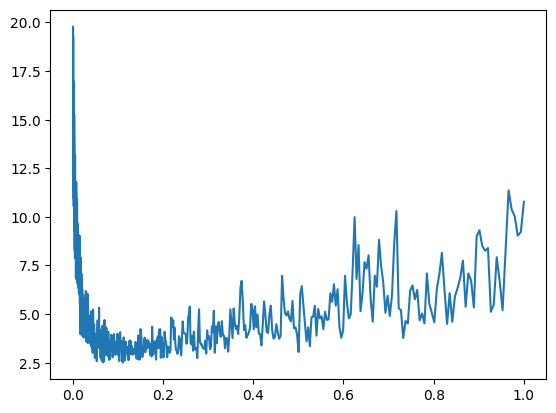

In [149]:
plt.plot(lri,lossi)

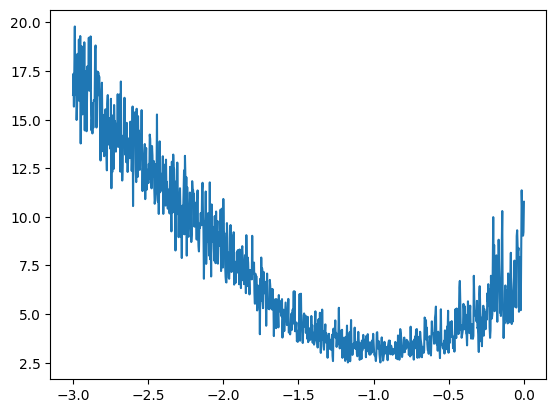

In [150]:
# 10**-1 was actually good
plt.plot(np.log10(lri),lossi)

In [ ]:
0.1 

**Observations**

- Beginning was too low
- Then around somewhere it started getting too big and got unstable
- Pick the region where it was consistent
- Good lr is on the consistent region

## Lets crank up the iterations and do it again

In [151]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [152]:
for p in parameters:
    p.requires_grad= True

In [159]:
# Mini-batch GD
epoch = 50000
batch_size = 32
for _ in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,X.shape[0],(batch_size,))
    mini_batch = X[ixs,:]
    mini_batch_y = Y[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01
    for p in parameters:
        p.data += - l_r* p.grad


In [160]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.2805490493774414

In [ ]:
# Then lets decay the learning rate after 30k iterations
# We already surpassed the bigram error which was 2.45

### Overfitting 

- We already surpassed the bigram error which was 2.45
- But this doesnt mean that our model is actually better
- Since we have 3481 parameters, it is easier to overfit
- Better approach is to have a train/dev/test split
- Evaluate hyperparam changes on the dev set 
- Compare results on test set (compare with other model)
- Do the last comparison sparingly because we would overfit to test set

## Data Splitting


In [161]:
# build dataset

def build_dataset(words):
    block_size = 3 # context length

    X,Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

#random shuffling
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1]) # 80%
Xdev,Ydev = build_dataset(words[n1:n2]) # 10%
Xte,Yte = build_dataset(words[n2:]) # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [162]:
torch.cat([Xtr,Xdev,Xte],dim=0).shape == X.shape

True

In [163]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [165]:
for p in parameters:
    p.requires_grad= True

In [169]:
# Mini-batch GD
# Only train on Xtr
epoch = 10000
batch_size = 32
for _ in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,))
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update
    l_r = 0.1
    for p in parameters:
        p.data += - l_r* p.grad
print(loss.item())

2.6261894702911377


In [170]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.480919361114502

In [171]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.4899253845214844

In [ ]:
0.1 

### Underfitting

Bias (training error) vs Variance (training error vs dev error) tradeoff.

- High Bias Low Variance (underfitting)
- Low Bias High Variance (overfitting)
- Low bias low variance



.

- Our training loss is big 2.34
- But our dev and train losses are quite similar (low variance)
- This means we are definitely underfitting (high bias)
- We can solve this by scaling up the size of the network

In [194]:
hidden_size = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad= True

In [195]:
sum(p.nelement() for p in parameters)

11897

In [196]:
stepi = []
lossi = []

In [197]:
# Mini-batch GD
# Only train on Xtr
epoch = 50000
batch_size = 32
for i in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,))
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,30) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update
    l_r = 0.01
    for p in parameters:
        p.data += - l_r* p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.571397066116333


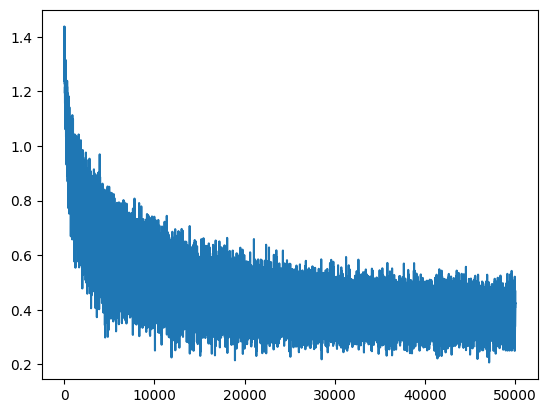

In [198]:
# noisy due to mini-batch
# increasing batch size would help us remove the mini-batch noise
plt.plot(stepi,lossi)

In [188]:
# dev eval
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1826791763305664

In [189]:
# train eval
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.154010772705078

- Another point is that maybe embedding dim is too low
- Might consider increasing that as well

In [192]:
C.shape

torch.Size([27, 10])

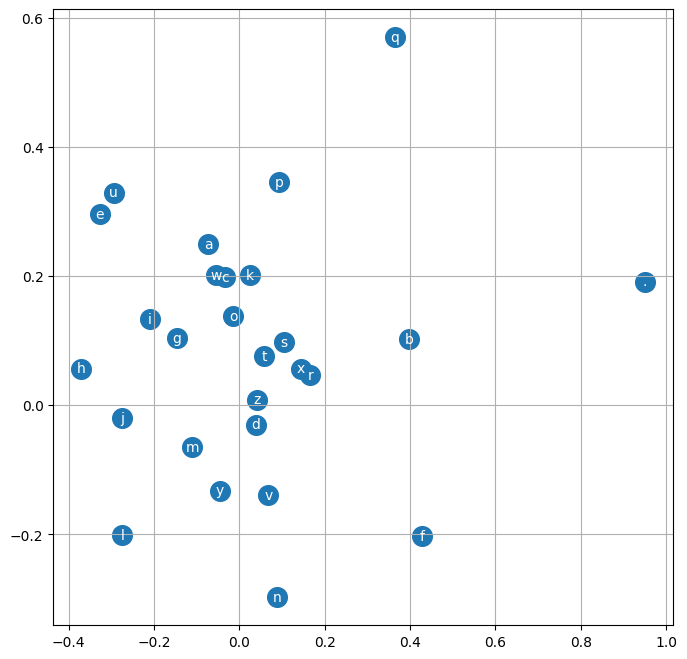

In [193]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
x_dim = 0
y_dim = 1
plt.scatter(C[:,x_dim].data, C[:,y_dim].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,x_dim].item(), C[i,y_dim].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

**Observations**
- See that vowels nicely clustered together!!!
- q is unique
- . is separate

- Last thing we try is we moved embedding dim from 2 to 10. 
- Learning rate decay is also done manually several times 
- See if we improve the final performance

### Overfit 
- Now our model is larger 
- We might start seeing train loss is getting separated from dev loss
- This is a sign that finally we have enough capacity to overfit.


**Things to improve perf.**

- block size different
- embedding size different
- How long we run
- hidden size
- batch size
- learning rate.


### Challenge

Try to beat the 2.13 dev score  achieved about.


### Finally

Sample from the model

In [291]:
# Sample from the trained model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nihah.
larethruthng.
leg.
adelyn.
elin.
shy.
jenne.
elissopharleilyn.
houra.
noshuberglairiel.
kin.
renlynn.
nopulfy.
brence.
ryylene.
elsyn.
ajahshournihia.
